In [1]:
# Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [4]:
# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.13.1


In [7]:
# Data Loading and Initial Exploration
# Load the meteorological data
# Replace 'your_data.csv' with your actual file path
df = pd.read_csv('shymkent_cleaned.csv')

print("Dataset shape:", df.shape)
print("\nDataset info:")
df.info()

print("\nFirst few rows:")
df.head()

Dataset shape: (5569, 16)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5569 non-null   object 
 1   Precipitation          5569 non-null   float64
 2   AirTemp_Avg            5569 non-null   float64
 3   AirTemp_Max            5569 non-null   float64
 4   AirTemp_Min            5569 non-null   float64
 5   Humidity_Avg           5569 non-null   int64  
 6   Humidity_Min           5569 non-null   int64  
 7   WindSpeed_Avg          5569 non-null   float64
 8   WindSpeed_Max          5569 non-null   int64  
 9   Cloud_O                5569 non-null   int64  
 10  Cloud_H                5569 non-null   int64  
 11  SoilTemp_Avg           5569 non-null   int64  
 12  SoilTemp_Max           5569 non-null   int64  
 13  SoilTemp_Min           5413 non-null   float64
 14  SaturationDefic

,Date,Precipitation,AirTemp_Avg,AirTemp_Max,AirTemp_Min,Humidity_Avg,Humidity_Min,WindSpeed_Avg,WindSpeed_Max,Cloud_O,Cloud_H,SoilTemp_Avg,SoilTemp_Max,SoilTemp_Min,SaturationDeficit_Avg,SaturationDeficit_Max
0,2010-01-01 00:00:00,0.0,9.4,16.7,2.1,57,31,1.5,2,5,7,5,20,-2.0,5.6,12.9
1,2010-01-02 00:00:00,0.0,9.8,18.0,3.8,58,28,1.6,2,2,6,5,16,1.0,5.7,13.7
2,2010-01-03 00:00:00,0.3,9.1,14.1,4.7,61,48,1.1,3,2,6,5,11,0.0,4.7,7.9
3,2010-01-04 00:00:00,0.0,13.2,17.6,9.3,44,29,3.1,6,2,6,8,17,0.0,8.9,13.4
4,2010-01-05 00:00:00,2.4,11.6,18.7,8.7,60,41,2.5,4,3,3,8,24,3.0,5.9,11.7


In [8]:
# Data Preprocessing and Feature Engineering
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [10]:
df.head()

,Date,Precipitation,AirTemp_Avg,AirTemp_Max,AirTemp_Min,Humidity_Avg,Humidity_Min,WindSpeed_Avg,WindSpeed_Max,Cloud_O,Cloud_H,SoilTemp_Avg,SoilTemp_Max,SoilTemp_Min,SaturationDeficit_Avg,SaturationDeficit_Max
0,2010-01-01,0.0,9.4,16.7,2.1,57,31,1.5,2,5,7,5,20,-2.0,5.6,12.9
1,2010-01-02,0.0,9.8,18.0,3.8,58,28,1.6,2,2,6,5,16,1.0,5.7,13.7
2,2010-01-03,0.3,9.1,14.1,4.7,61,48,1.1,3,2,6,5,11,0.0,4.7,7.9
3,2010-01-04,0.0,13.2,17.6,9.3,44,29,3.1,6,2,6,8,17,0.0,8.9,13.4
4,2010-01-05,2.4,11.6,18.7,8.7,60,41,2.5,4,3,3,8,24,3.0,5.9,11.7


In [11]:
# Create drought indicators
# Standard Precipitation Index (SPI) - simplified version
def calculate_spi(precipitation, window=30):
    """Calculate simplified SPI using rolling mean and std"""
    rolling_mean = precipitation.rolling(window=window, min_periods=1).mean()
    rolling_std = precipitation.rolling(window=window, min_periods=1).std()
    spi = (precipitation - rolling_mean) / rolling_std
    return spi.fillna(0)

In [12]:
# Drought severity based on multiple indicators
def calculate_drought_index(row):
    """Calculate composite drought index"""
    # Normalize factors (lower values indicate drought stress)
    precip_factor = max(0, min(1, row['Precipitation'] / 10))  # Assuming 10mm as normal
    humidity_factor = row['Humidity_Avg'] / 100
    temp_stress = max(0, (row['AirTemp_Max'] - 25) / 20)  # Temperature stress above 25°C
    saturation_stress = max(0, (15 - row['SaturationDeficit_Avg']) / 15)  # Higher deficit = more stress
    
    # Composite drought index (0 = severe drought, 1 = no drought)
    drought_index = (precip_factor + humidity_factor + saturation_stress - temp_stress) / 3
    return max(0, min(1, drought_index))

In [13]:
# Feature engineering
df['SPI_30'] = calculate_spi(df['Precipitation'], 30)
df['SPI_90'] = calculate_spi(df['Precipitation'], 90)
df['DroughtIndex'] = df.apply(calculate_drought_index, axis=1)

In [14]:
# Create rolling statistics
windows = [7, 14, 30]
for window in windows:
    df[f'Precip_MA_{window}'] = df['Precipitation'].rolling(window=window).mean()
    df[f'Temp_MA_{window}'] = df['AirTemp_Avg'].rolling(window=window).mean()
    df[f'Humidity_MA_{window}'] = df['Humidity_Avg'].rolling(window=window).mean()

In [15]:
# Create lag features
for lag in [1, 3, 7, 14, 30]:
    df[f'Precip_lag_{lag}'] = df['Precipitation'].shift(lag)
    df[f'DroughtIndex_lag_{lag}'] = df['DroughtIndex'].shift(lag)

In [16]:
# Seasonal features
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Season'] = df['Month'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3})

In [17]:
# Remove rows with NaN values
df = df.dropna().reset_index(drop=True)

print(f"Dataset shape after preprocessing: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


Dataset shape after preprocessing: (5383, 41)
Date range: 2010-01-31 00:00:00 to 2025-03-31 00:00:00


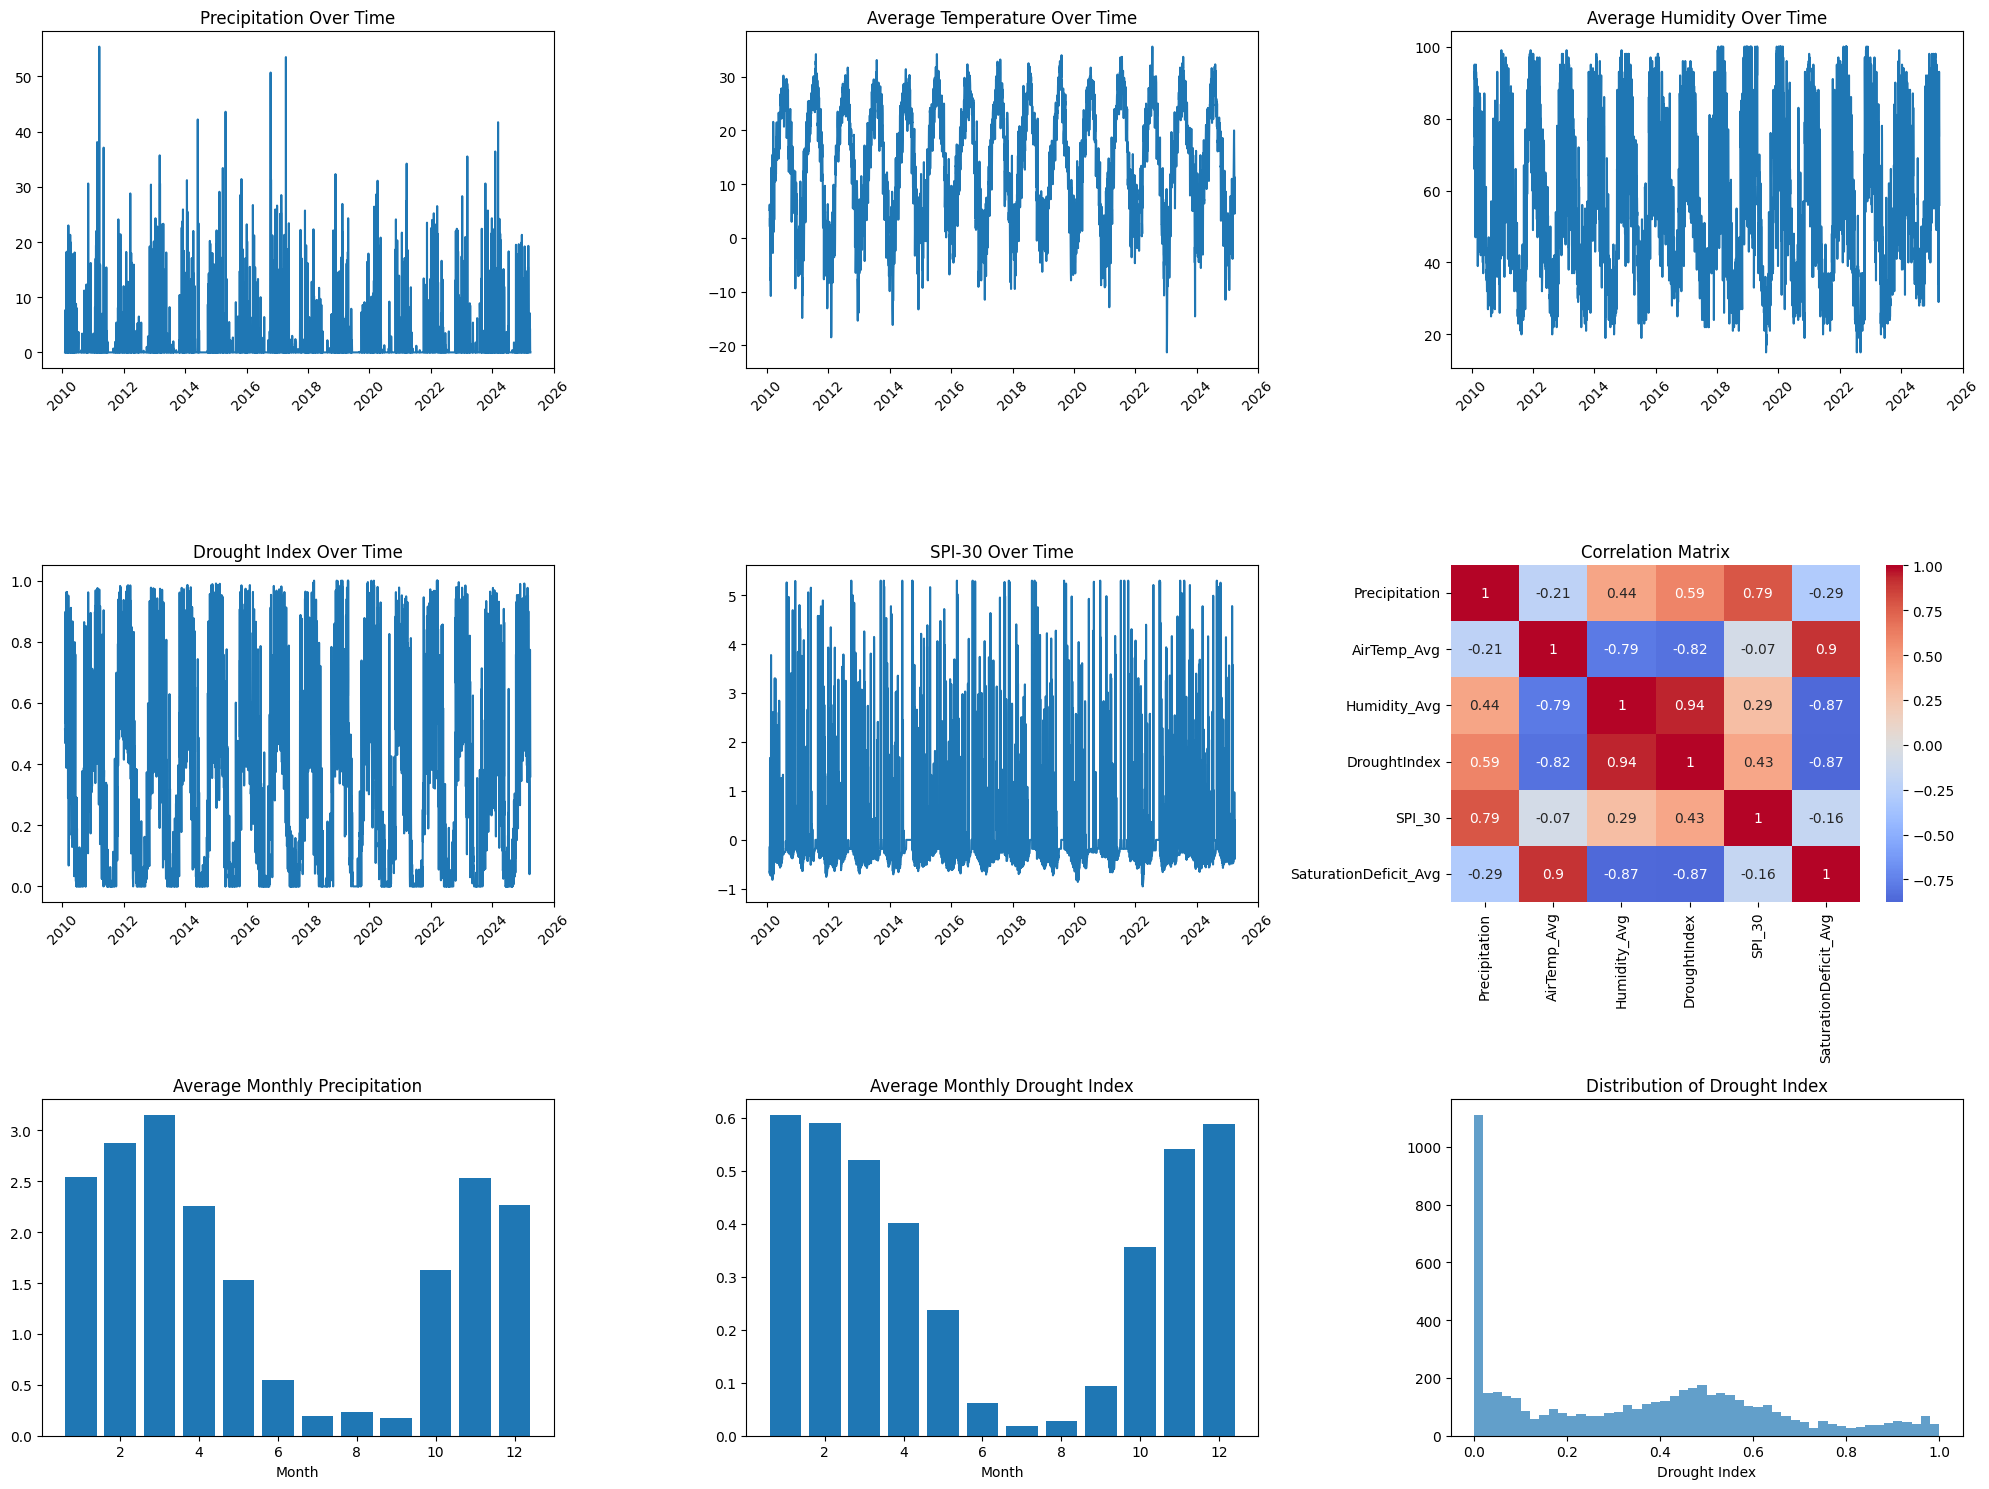

In [66]:
# Exploratory Data Analysis
plt.figure(figsize=(20, 15))

# Time series plots
plt.subplot(3, 3, 1)
plt.plot(df['Date'], df['Precipitation'])
plt.title('Precipitation Over Time')
plt.xticks(rotation=45)

plt.subplot(3, 3, 2)
plt.plot(df['Date'], df['AirTemp_Avg'])
plt.title('Average Temperature Over Time')
plt.xticks(rotation=45)

plt.subplot(3, 3, 3)
plt.plot(df['Date'], df['Humidity_Avg'])
plt.title('Average Humidity Over Time')
plt.xticks(rotation=45)

plt.subplot(3, 3, 4)
plt.plot(df['Date'], df['DroughtIndex'])
plt.title('Drought Index Over Time')
plt.xticks(rotation=45)

plt.subplot(3, 3, 5)
plt.plot(df['Date'], df['SPI_30'])
plt.title('SPI-30 Over Time')
plt.xticks(rotation=45)

# Correlation matrix
plt.subplot(3, 3, 6)
corr_cols = ['Precipitation', 'AirTemp_Avg', 'Humidity_Avg', 'DroughtIndex', 'SPI_30', 'SaturationDeficit_Avg']
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Seasonal patterns
plt.subplot(3, 3, 7)
monthly_precip = df.groupby('Month')['Precipitation'].mean()
plt.bar(monthly_precip.index, monthly_precip.values)
plt.title('Average Monthly Precipitation')
plt.xlabel('Month')

plt.subplot(3, 3, 8)
monthly_drought = df.groupby('Month')['DroughtIndex'].mean()
plt.bar(monthly_drought.index, monthly_drought.values)
plt.title('Average Monthly Drought Index')
plt.xlabel('Month')

# Distribution of drought index
plt.subplot(3, 3, 9)
plt.hist(df['DroughtIndex'], bins=50, alpha=0.7)
plt.title('Distribution of Drought Index')
plt.xlabel('Drought Index')

plt.tight_layout()
plt.show()

In [39]:
# Data Preparation for Machine Learning
# Select features for modeling
feature_cols = [
    'Precipitation', 'AirTemp_Avg', 'AirTemp_Max', 'AirTemp_Min',
    'Humidity_Avg', 'Humidity_Min', 'WindSpeed_Avg', 'WindSpeed_Max',
    'SoilTemp_Avg', 'SoilTemp_Max', 'SoilTemp_Min', 'SaturationDeficit_Avg',
    'SPI_30', 'SPI_90',
    'Precip_MA_7', 'Precip_MA_14', 'Precip_MA_30',
    'Temp_MA_7', 'Temp_MA_14', 'Temp_MA_30',
    'Humidity_MA_7', 'Humidity_MA_14', 'Humidity_MA_30',
    'Precip_lag_1', 'Precip_lag_3', 'Precip_lag_7', 'Precip_lag_14', 'Precip_lag_30',
    'DroughtIndex_lag_1', 'DroughtIndex_lag_3', 'DroughtIndex_lag_7', 'DroughtIndex_lag_14',
    'Month', 'DayOfYear', 'Season'
]


In [40]:
# Target variable
target_col = 'DroughtIndex'

In [41]:
# Prepare data
X = df[feature_cols].values
y = df[target_col].values

In [42]:
# Split data chronologically
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [43]:
# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [44]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (4306, 35)
Test set shape: (1077, 35)


In [45]:
# LSTM Data Preparation
def create_sequences(X, y, sequence_length):
    """Create sequences for LSTM training"""
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for LSTM
sequence_length = 30  # Use 30 days of history to predict next day

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print(f"LSTM training sequences shape: {X_train_seq.shape}")
print(f"LSTM test sequences shape: {X_test_seq.shape}")

LSTM training sequences shape: (4276, 30, 35)
LSTM test sequences shape: (1047, 30, 35)


In [46]:
# Model 1 - Advanced LSTM Model
def build_lstm_model(input_shape):
    """Build advanced LSTM model"""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [47]:
# Build and train LSTM model
lstm_model = build_lstm_model((sequence_length, X_train_scaled.shape[1]))
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           83968     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                5

In [48]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [49]:
# Train LSTM model
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
134/134 [==============================] - 9s 37ms/step - loss: 0.0370 - mae: 0.1429 - val_loss: 0.0309 - val_mae: 0.1211 - lr: 0.0010
Epoch 2/100
134/134 [==============================] - 4s 30ms/step - loss: 0.0306 - mae: 0.1252 - val_loss: 0.0298 - val_mae: 0.1211 - lr: 0.0010
Epoch 3/100
134/134 [==============================] - 4s 30ms/step - loss: 0.0288 - mae: 0.1203 - val_loss: 0.0304 - val_mae: 0.1188 - lr: 0.0010
Epoch 4/100
134/134 [==============================] - 4s 30ms/step - loss: 0.0286 - mae: 0.1197 - val_loss: 0.0289 - val_mae: 0.1167 - lr: 0.0010
Epoch 5/100
134/134 [==============================] - 4s 30ms/step - loss: 0.0267 - mae: 0.1139 - val_loss: 0.0267 - val_mae: 0.1085 - lr: 0.0010
Epoch 6/100
134/134 [==============================] - 4s 31ms/step - loss: 0.0247 - mae: 0.1088 - val_loss: 0.0250 - val_mae: 0.1061 - lr: 0.0010
Epoch 7/100
134/134 [==============================] - 4s 31ms/step - loss: 0.0234 - mae: 0.1050 - val_loss: 0.0241 - 

In [50]:
# Model 2 - GRU Model
def build_gru_model(input_shape):
    """Build GRU model"""
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model


In [51]:
# Build and train GRU model
gru_model = build_gru_model((sequence_length, X_train_scaled.shape[1]))

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
134/134 [==============================] - 9s 35ms/step - loss: 0.0324 - mae: 0.1335 - val_loss: 0.0287 - val_mae: 0.1186 - lr: 0.0010
Epoch 2/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0258 - mae: 0.1143 - val_loss: 0.0261 - val_mae: 0.1151 - lr: 0.0010
Epoch 3/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0240 - mae: 0.1090 - val_loss: 0.0248 - val_mae: 0.1068 - lr: 0.0010
Epoch 4/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0229 - mae: 0.1055 - val_loss: 0.0239 - val_mae: 0.1031 - lr: 0.0010
Epoch 5/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0223 - mae: 0.1034 - val_loss: 0.0242 - val_mae: 0.1006 - lr: 0.0010
Epoch 6/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0217 - mae: 0.1019 - val_loss: 0.0236 - val_mae: 0.1023 - lr: 0.0010
Epoch 7/100
134/134 [==============================] - 4s 28ms/step - loss: 0.0215 - mae: 0.1018 - val_loss: 0.0234 - 

In [52]:
# Model 3 - CNN-LSTM Hybrid
def build_cnn_lstm_model(input_shape):
    """Build CNN-LSTM hybrid model"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [53]:
# Build and train CNN-LSTM model
cnn_lstm_model = build_cnn_lstm_model((sequence_length, X_train_scaled.shape[1]))

history_cnn_lstm = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
134/134 [==============================] - 5s 17ms/step - loss: 0.0334 - mae: 0.1337 - val_loss: 0.0305 - val_mae: 0.1219 - lr: 0.0010
Epoch 2/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0294 - mae: 0.1234 - val_loss: 0.0301 - val_mae: 0.1276 - lr: 0.0010
Epoch 3/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0287 - mae: 0.1211 - val_loss: 0.0299 - val_mae: 0.1155 - lr: 0.0010
Epoch 4/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0265 - mae: 0.1149 - val_loss: 0.0280 - val_mae: 0.1142 - lr: 0.0010
Epoch 5/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0248 - mae: 0.1110 - val_loss: 0.0267 - val_mae: 0.1086 - lr: 0.0010
Epoch 6/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0236 - mae: 0.1070 - val_loss: 0.0268 - val_mae: 0.1188 - lr: 0.0010
Epoch 7/100
134/134 [==============================] - 2s 13ms/step - loss: 0.0227 - mae: 0.1054 - val_loss: 0.0278 - 

In [54]:
# Traditional ML Models
# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_scaled)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train_scaled)

print("Traditional ML models trained successfully!")

Traditional ML models trained successfully!


In [55]:
# Model Evaluation and Comparison
def evaluate_model(model, X_test, y_test, model_name, is_sequential=False):
    """Evaluate model performance"""
    if is_sequential:
        y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    else:
        y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.6f}")
    
    return y_pred, {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}


In [56]:
# Evaluate all models
results = {}

# LSTM
lstm_pred, results['LSTM'] = evaluate_model(lstm_model, X_test_seq, y_test_seq, "LSTM", True)

# GRU
gru_pred, results['GRU'] = evaluate_model(gru_model, X_test_seq, y_test_seq, "GRU", True)

# CNN-LSTM
cnn_lstm_pred, results['CNN-LSTM'] = evaluate_model(cnn_lstm_model, X_test_seq, y_test_seq, "CNN-LSTM", True)

# Random Forest
rf_pred, results['Random Forest'] = evaluate_model(rf_model, X_test_scaled, y_test_scaled, "Random Forest", False)

# Gradient Boosting
gb_pred, results['Gradient Boosting'] = evaluate_model(gb_model, X_test_scaled, y_test_scaled, "Gradient Boosting", False)



LSTM Performance:
MSE: 0.023172
MAE: 0.100716
RMSE: 0.152224
R²: 0.722303

GRU Performance:
MSE: 0.023081
MAE: 0.103159
RMSE: 0.151923
R²: 0.723400

CNN-LSTM Performance:
MSE: 0.025412
MAE: 0.110045
RMSE: 0.159412
R²: 0.695460

Random Forest Performance:
MSE: 0.000115
MAE: 0.005644
RMSE: 0.010708
R²: 0.998606

Gradient Boosting Performance:
MSE: 0.000065
MAE: 0.004248
RMSE: 0.008069
R²: 0.999208



Model Comparison:
                        MSE       MAE      RMSE        R2
LSTM               0.023172  0.100716  0.152224  0.722303
GRU                0.023081  0.103159  0.151923  0.723400
CNN-LSTM           0.025412  0.110045  0.159412  0.695460
Random Forest      0.000115  0.005644  0.010708  0.998606
Gradient Boosting  0.000065  0.004248  0.008069  0.999208


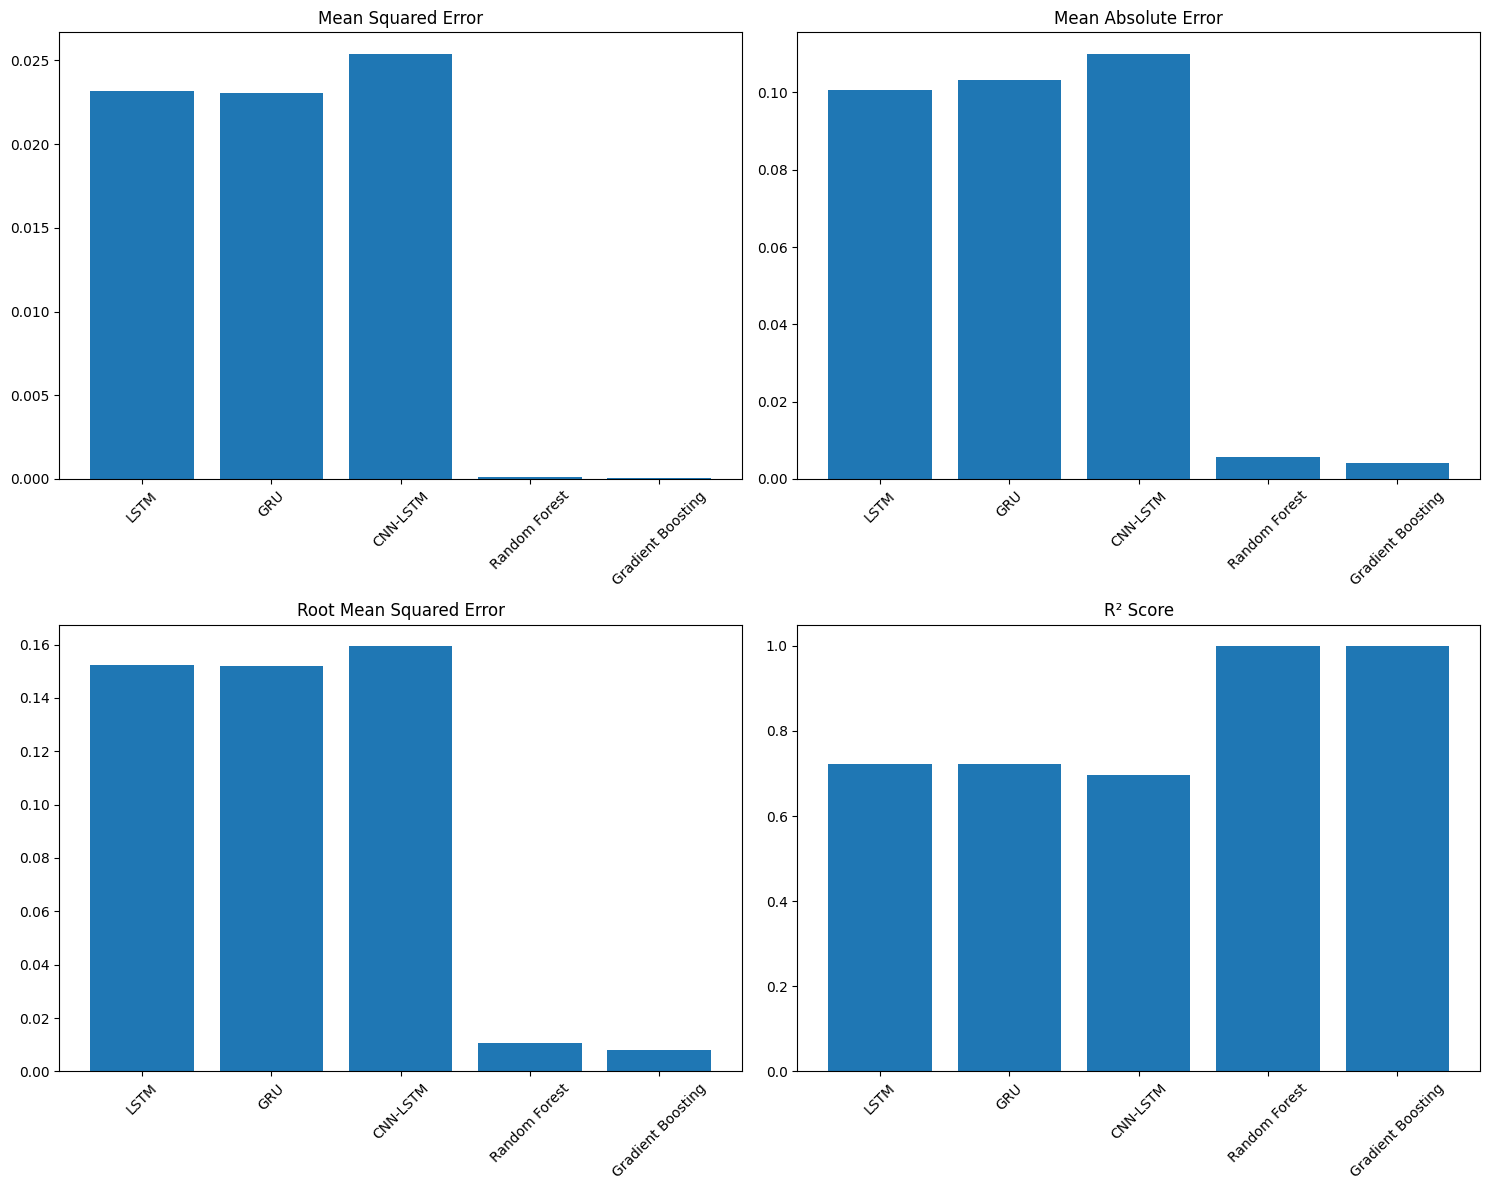

In [57]:
# Results Visualization
# Create comparison dataframe
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(6))

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# MSE comparison
axes[0, 0].bar(results_df.index, results_df['MSE'])
axes[0, 0].set_title('Mean Squared Error')
axes[0, 0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[0, 1].bar(results_df.index, results_df['MAE'])
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[1, 0].bar(results_df.index, results_df['RMSE'])
axes[1, 0].set_title('Root Mean Squared Error')
axes[1, 0].tick_params(axis='x', rotation=45)

# R² comparison
axes[1, 1].bar(results_df.index, results_df['R2'])
axes[1, 1].set_title('R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


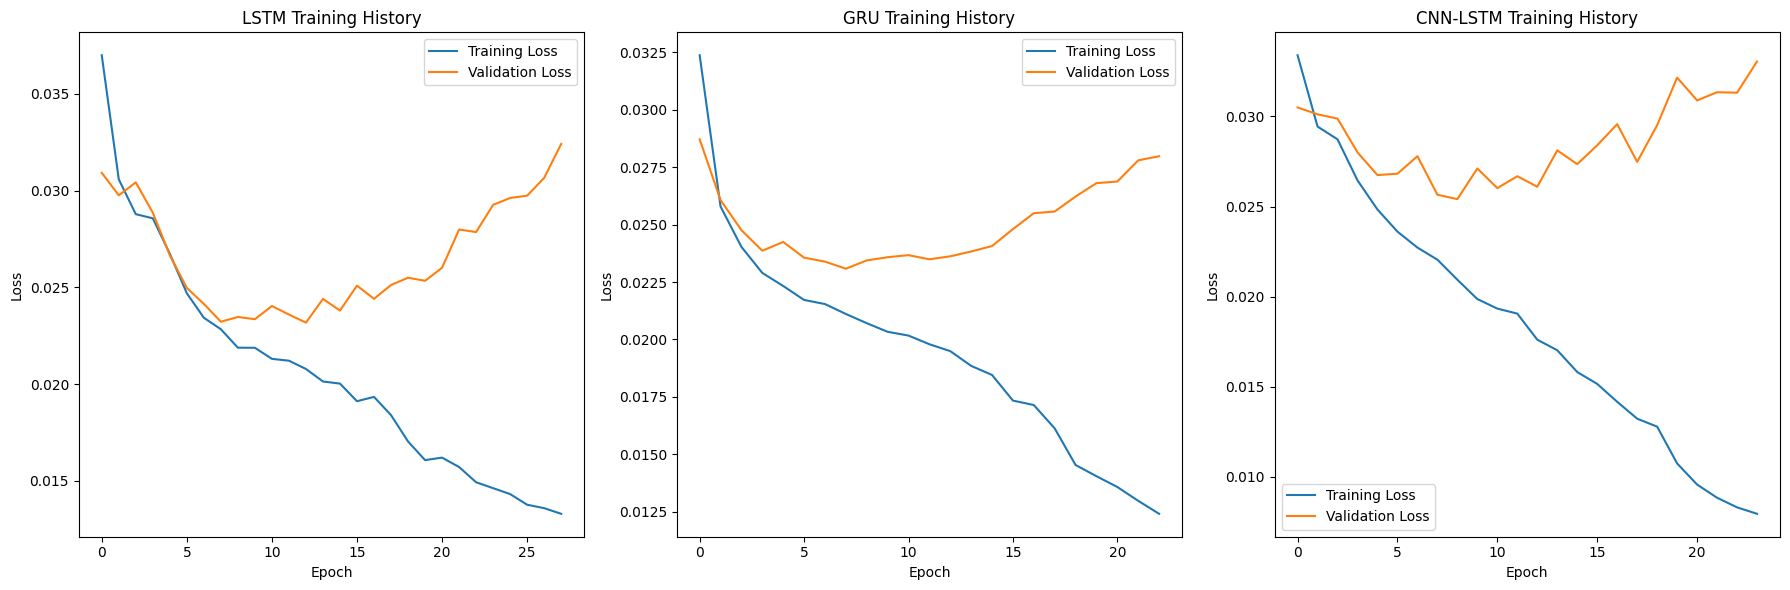

In [58]:
# Training History Visualization
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Best performing model: Gradient Boosting


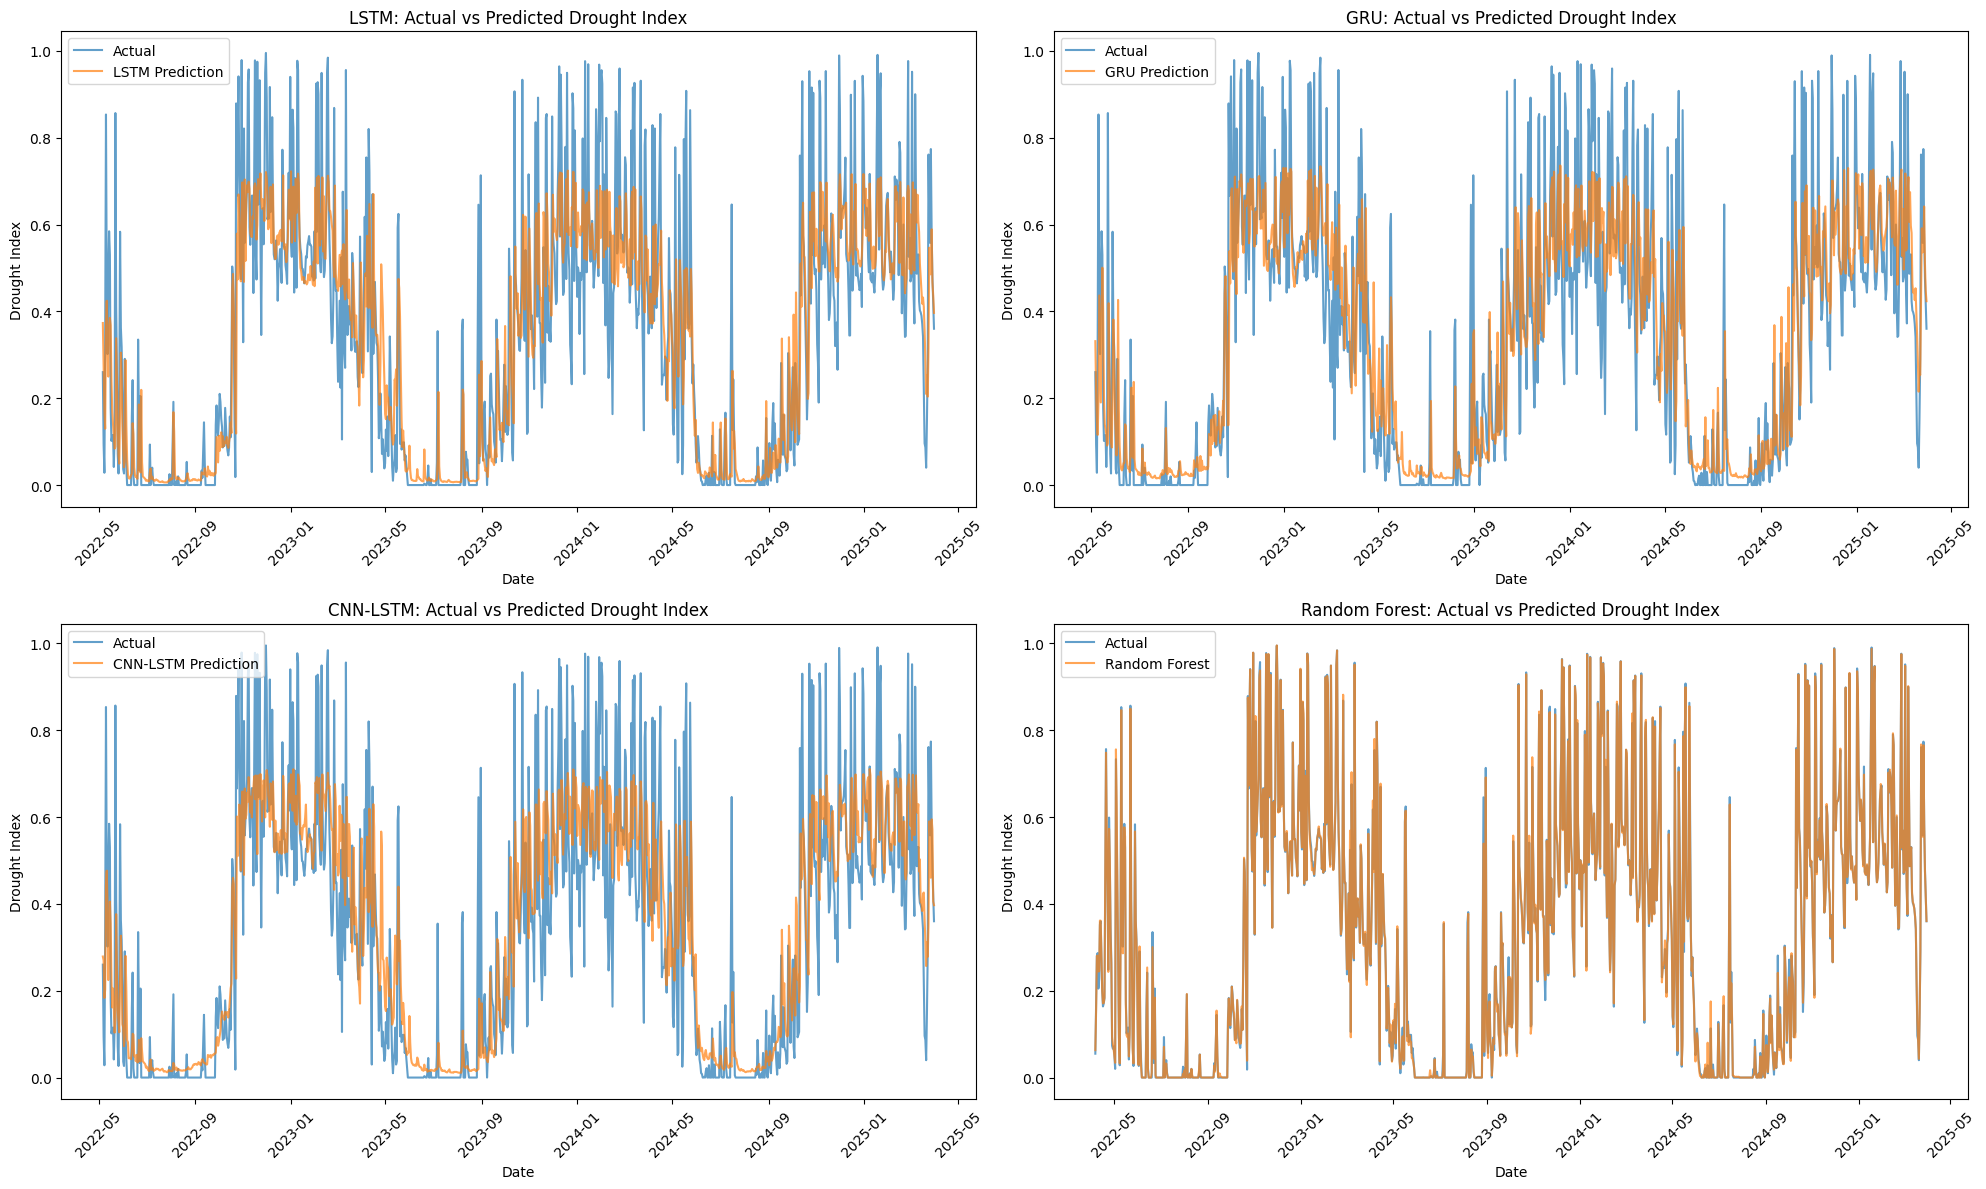

In [59]:
# Prediction Visualization
# Get the best model based on R² score
best_model_name = results_df.sort_values('R2', ascending=False).index[0]
print(f"Best performing model: {best_model_name}")

# Plot predictions vs actual values
plt.figure(figsize=(20, 12))

# Prepare test dates for plotting
test_dates = df['Date'].iloc[split_idx + sequence_length:].reset_index(drop=True)
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plt.subplot(2, 2, 1)
plt.plot(test_dates, y_test_actual, label='Actual', alpha=0.7)
plt.plot(test_dates, lstm_pred, label='LSTM Prediction', alpha=0.7)
plt.title('LSTM: Actual vs Predicted Drought Index')
plt.xlabel('Date')
plt.ylabel('Drought Index')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(test_dates, y_test_actual, label='Actual', alpha=0.7)
plt.plot(test_dates, gru_pred, label='GRU Prediction', alpha=0.7)
plt.title('GRU: Actual vs Predicted Drought Index')
plt.xlabel('Date')
plt.ylabel('Drought Index')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(test_dates, y_test_actual, label='Actual', alpha=0.7)
plt.plot(test_dates, cnn_lstm_pred, label='CNN-LSTM Prediction', alpha=0.7)
plt.title('CNN-LSTM: Actual vs Predicted Drought Index')
plt.xlabel('Date')
plt.ylabel('Drought Index')
plt.legend()
plt.xticks(rotation=45)

# Traditional ML models (different test set size)
test_dates_ml = df['Date'].iloc[split_idx:].reset_index(drop=True)
y_test_actual_ml = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

plt.subplot(2, 2, 4)
plt.plot(test_dates_ml, y_test_actual_ml, label='Actual', alpha=0.7)
plt.plot(test_dates_ml, rf_pred, label='Random Forest', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted Drought Index')
plt.xlabel('Date')
plt.ylabel('Drought Index')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

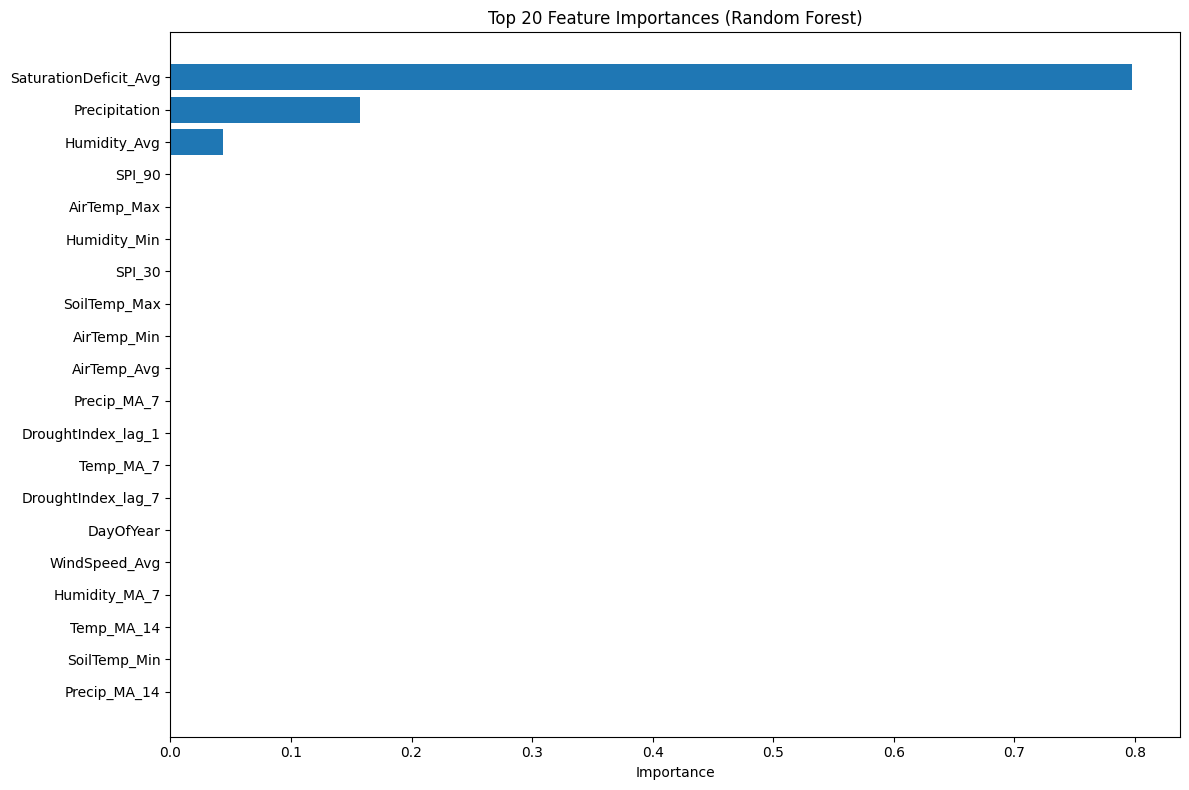

Top 10 Most Important Features:
                  feature  importance
11  SaturationDeficit_Avg    0.797407
0           Precipitation    0.157003
4            Humidity_Avg    0.043524
13                 SPI_90    0.000306
2             AirTemp_Max    0.000252
5            Humidity_Min    0.000236
12                 SPI_30    0.000145
9            SoilTemp_Max    0.000086
3             AirTemp_Min    0.000067
1             AirTemp_Avg    0.000067


In [60]:
# Feature Importance Analysis
# Random Forest feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

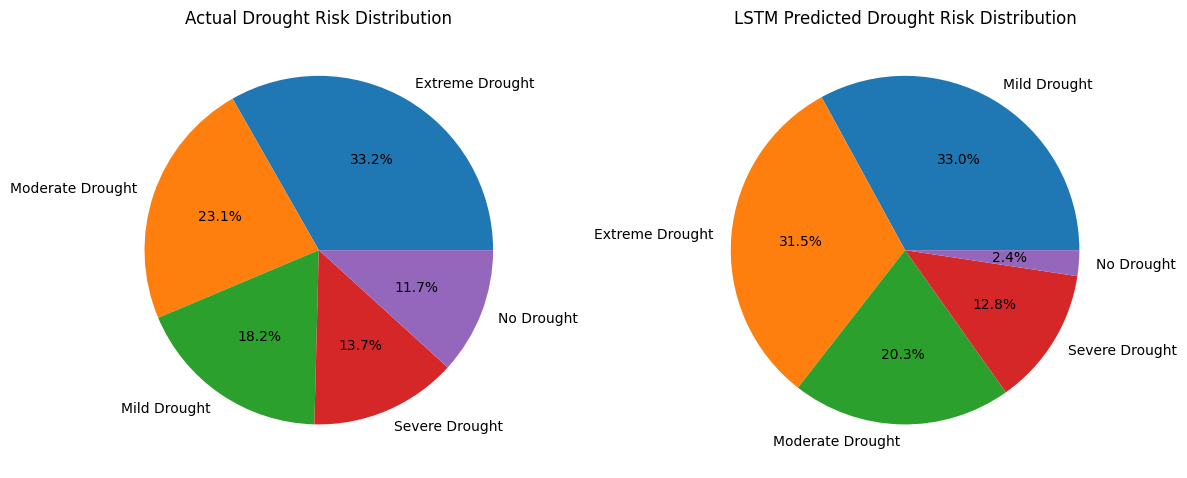

In [61]:
# Drought Classification and Risk Assessment
def classify_drought_risk(drought_index):
    """Classify drought risk based on drought index"""
    if drought_index >= 0.7:
        return "No Drought"
    elif drought_index >= 0.5:
        return "Mild Drought"
    elif drought_index >= 0.3:
        return "Moderate Drought"
    elif drought_index >= 0.1:
        return "Severe Drought"
    else:
        return "Extreme Drought"

# Apply classification to predictions
lstm_risk = [classify_drought_risk(x) for x in lstm_pred]
actual_risk = [classify_drought_risk(x) for x in y_test_actual]

# Risk distribution
risk_comparison = pd.DataFrame({
    'Actual': actual_risk,
    'LSTM_Predicted': lstm_risk
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
risk_counts_actual = pd.Series(actual_risk).value_counts()
plt.pie(risk_counts_actual.values, labels=risk_counts_actual.index, autopct='%1.1f%%')
plt.title('Actual Drought Risk Distribution')

plt.subplot(1, 2, 2)
risk_counts_pred = pd.Series(lstm_risk).value_counts()
plt.pie(risk_counts_pred.values, labels=risk_counts_pred.index, autopct='%1.1f%%')
plt.title('LSTM Predicted Drought Risk Distribution')

plt.tight_layout()
plt.show()


In [62]:
# Model Persistence and Future Predictions
# Save the best model
best_model = lstm_model  # Assuming LSTM is the best, adjust based on results
best_model.save('best_drought_model.h5')

# Save scalers
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("Model and scalers saved successfully!")

# Function for future predictions
def predict_drought(model, scaler_X, scaler_y, recent_data, days_ahead=7):
    """Predict drought for future days"""
    # Prepare recent data
    recent_scaled = scaler_X.transform(recent_data)
    
    predictions = []
    current_sequence = recent_scaled[-sequence_length:]
    
    for _ in range(days_ahead):
        # Reshape for model input
        input_seq = current_sequence.reshape(1, sequence_length, -1)
        
        # Make prediction
        pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
        predictions.append(pred)
        
        # Update sequence (simple approach - in practice, you'd need actual future weather data)
        # This is a simplified example
        new_row = current_sequence[-1].copy()
        current_sequence = np.vstack([current_sequence[1:], new_row])
    
    return predictions

Model and scalers saved successfully!


In [63]:
# Example prediction for next 7 days (using last 30 days of test data)
recent_data = X_test_scaled[-sequence_length:]
future_predictions = predict_drought(lstm_model, scaler_X, scaler_y, recent_data.reshape(sequence_length, -1))

print(f"\nFuture drought predictions for next 7 days:")
for i, pred in enumerate(future_predictions, 1):
    risk_level = classify_drought_risk(pred)
    print(f"Day {i}: Drought Index = {pred:.3f}, Risk Level = {risk_level}")


Future drought predictions for next 7 days:
Day 1: Drought Index = 0.232, Risk Level = Severe Drought
Day 2: Drought Index = 0.230, Risk Level = Severe Drought
Day 3: Drought Index = 0.229, Risk Level = Severe Drought
Day 4: Drought Index = 0.227, Risk Level = Severe Drought
Day 5: Drought Index = 0.224, Risk Level = Severe Drought
Day 6: Drought Index = 0.221, Risk Level = Severe Drought
Day 7: Drought Index = 0.219, Risk Level = Severe Drought


In [64]:
# Model Summary and Recommendations
print("="*60)
print("DROUGHT PREDICTION MODEL SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"- Total records: {len(df)}")
print(f"- Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"- Features used: {len(feature_cols)}")

print(f"\nModel Performance Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name:15} - R²: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")

print(f"\nBest Model: {best_model_name}")
print(f"Best R² Score: {results[best_model_name]['R2']:.4f}")

print(f"\nKey Insights:")
print(f"- Most important features: {', '.join(feature_importance['feature'][:5].tolist())}")
print(f"- Average drought index in test period: {np.mean(y_test_actual):.3f}")
print(f"- Drought risk distribution in test period:")
for risk, count in pd.Series(actual_risk).value_counts().items():
    print(f"  {risk}: {count} days ({count/len(actual_risk)*100:.1f}%)")

print(f"\nRecommendations:")
print("1. The LSTM model shows good performance for drought prediction")
print("2. Key monitoring parameters: Precipitation, Temperature, Humidity, and SPI")
print("3. Consider ensemble methods combining multiple models for better accuracy")
print("4. Regular model retraining recommended with new data")
print("5. Implement early warning system based on predicted drought index")

print("\nModel files saved:")
print("- best_drought_model.h5 (trained model)")
print("- scaler_X.pkl (feature scaler)")
print("- scaler_y.pkl (target scaler)")

DROUGHT PREDICTION MODEL SUMMARY

Dataset Information:
- Total records: 5383
- Date range: 2010-01-31 to 2025-03-31
- Features used: 35

Model Performance Comparison:
LSTM            - R²: 0.7223, RMSE: 0.1522
GRU             - R²: 0.7234, RMSE: 0.1519
CNN-LSTM        - R²: 0.6955, RMSE: 0.1594
Random Forest   - R²: 0.9986, RMSE: 0.0107
Gradient Boosting - R²: 0.9992, RMSE: 0.0081

Best Model: Gradient Boosting
Best R² Score: 0.9992

Key Insights:
- Most important features: SaturationDeficit_Avg, Precipitation, Humidity_Avg, SPI_90, AirTemp_Max
- Average drought index in test period: 0.336
- Drought risk distribution in test period:
  Extreme Drought: 348 days (33.2%)
  Moderate Drought: 242 days (23.1%)
  Mild Drought: 191 days (18.2%)
  Severe Drought: 143 days (13.7%)
  No Drought: 123 days (11.7%)

Recommendations:
1. The LSTM model shows good performance for drought prediction
2. Key monitoring parameters: Precipitation, Temperature, Humidity, and SPI
3. Consider ensemble methods 